In [1]:
#import av
import numpy as np
import math
#import trackpy
#import matplotlib #for making plots inside the notebook 
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vread
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(idir):
    iner = idir.inertia_tensor[0, 0] + idir.inertia_tensor[1, 1]
    maal = idir.major_axis_length
    mial = idir.minor_axis_length
    sol = idir.solidity 
    ecc = idir.eccentricity
    cva = idir.convex_area
    area = idir.area
    if 1 == 0:
        return "ucf"
    elif ecc > 0.79 and  iner > 330 and iner < 425: #cva > 1920 and cva < 2250:
        return "t"
    elif maal > 66 and maal < 74 and ecc < 0.81: # maal > 67.5 and or (mial < 41 and maal > 65): # it's on top
        return "b_m"
    elif  (maal<62.5 and ecc < 0.81): #or mial > 42  #and cva > 2200 and iner < 325: #or (maal < 64 and iner < 360): # it's on bottom
        return "b"
    else:
        return "ucf"

def classify(side, coprod):
    if side == "t":
        if coprod > 0:
            return "t_l"
        else:
            return "t_r"
    elif side == "b": 
        if coprod > 0:
            return "b_r"
        else:
            return "b_l"
    elif side == "b_m":
        return "b_m"
    elif side == "ucf":
        return "ucf"
    else:
        return "newt"


def coord_prod(thresh_y, thresh_i):
    m_rop = measure.regionprops
    for i in range(0, 1):#len(fl):
        full = largest_region_extractor(measure.label(thresh_y))
        four = largest_region_extractor(measure.label(thresh_i))
        full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
        one_and_some = full^four
        one = largest_region_extractor(measure.label(one_and_some))
        
          
        #Begin finding substitue for major and minor axes herre
        # use min and maax x and  values to find the geometric center
        # or use those to substitue for eigenvectors 
        rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
        rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
        geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
        #print(geo_cent)
        ave = np.average
        cent_x = ave([geo_cent[1], geo_cent[3]]) 
        cent_y = ave([geo_cent[0], geo_cent[2]])
        #print(cent_x, cent_y)
        
        raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
        ys = raw_coords[0]
        xs = raw_coords[1]
        x = xs - cent_x
        y = ys - cent_y      
        
        one_com = m_rop(rotated_one.astype(int))[0].centroid
        
        rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y)
        product = np.prod(rel_com_one)
        return product
        
def rotate_point(point, angle):
    x0 = point[0]
    y0 = point[1]
    x1 = x0*np.cos(angle) - y0*np.sin(angle)
    y1 = x0*np.sin(angle) + y0*np.cos(angle)
    return (x1, y1)
 
def region_selector(labeled_image, label):
    #print(label)
    x = labeled_image == label
    #plt.imshow(x)
    return x

# make a function that takes a set of labeled regions, and then  returns a boolean array containing only the largest
def largest_region_extractor(labeled_regions_set):
    props_lists = measure.regionprops(labeled_regions_set)
    #print(len(labeled_regions_set), len(props_lists))
    biggest_r_p = props_lists[0]
    biggest_r_label = props_lists[0].label
    for i in range(0, len(props_lists)):
        pli = props_lists[i]
        if pli.area > biggest_r_p.area:
            biggest_r_p = pli
            biggest_r_label = pli.label
        else:
            pass
    return region_selector(labeled_regions_set, biggest_r_label)    
#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
"Filtering broken ad oddframes"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    area_threshold = 1950  # must have enough particles
    convex_thresholds = (2000, 2800)   # convex hull area (> 2500 filtered)  # particles must be in parallelogram
    minor_thresholds = (41 , 50) # minor_axis length (< filterd) # particles must be in parallelogram
    major_thresholds = (60, 75)
    filtrate_prop =[]
    otp = []
    ttp = []
    imgs = []
    conditional = []
    trash = []
    
    for i in range(fll):
       # print("new_frame")
        frame = framelist[i]
        thresh_img = frame > threshold_li(frame) # binary image
        img_labelled = m_lab(thresh_img) # contains connected regions
        properties_list = m_rop(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = max(properties_list, key = attrgetter('area'))
        biggest_r = m_rop(morphology.dilation(morphology.closing(m_lab(biggest_r.filled_image))), coordinates='rc')[0]
        otp.append(biggest_r)
        
        i_threshed = frame > threshold_isodata(frame)
        img2_labelled = m_lab(i_threshed)
        properties2_list = m_rop(img2_labelled, coordinates = 'rc')
        biggest_r2 = max(properties2_list, key = attrgetter('area'))
        biggest_r2 = m_rop(morphology.erosion(morphology.opening(m_lab(biggest_r2.image))), coordinates='rc')[0]
        ttp.append(biggest_r2)
        
        imgs.append((img_labelled, img2_labelled))
        #----------------------filter------------------------- can use actual filter
        test = (biggest_r.filled_area > area_threshold 
                #and biggest_r.eccentricity < ecc_threshold and# must have enough particles
            #and biggest_r.minor_axis_length > minor_thresholds[0] # minor_axis length (< filterd) # particles must be in parallelogram
            #and biggest_r.minor_axis_length < minor_thresholds[1]  # minor_axis length (< filterd) # particles must be in parallelogram
            #and biggest_r.convex_area > convex_thresholds[0]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            #and biggest_r.convex_area < convex_thresholds[1]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            and biggest_r.major_axis_length > major_thresholds[0]  # major_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.major_axis_length < major_thresholds[1]   # major_axis length (< filterd) # particles must be in parallelogram
               )
        if test: # keep frames that have enough paricles, and are not transitions
            
            #-----------------------------classify pt 1---------------------------------------
            coprod = coord_prod(thresh_img, i_threshed)
            side = sideify(biggest_r2)
            clas = classify(side, -coprod)
            conditional.append(biggest_r2)
            if clas == framesetname:
                filtrate_prop.append((biggest_r, biggest_r2))
        else:
            trash.append(biggest_r)
    return [filtrate_prop, conditional, otp, ttp, imgs, trash]






In [4]:
"Retreving properties for test frames with 1st hreshold"
# applies yen filter to test frames, and gets properties
# returns list of the properties
#  fraemelist is a frame and a frame index
def opaque_threshold_properties(framelist, indes):
    filtrate = []
    for i in range(len(framelist)):
        frame = framelist[i]
        thresh_img = frame > threshold_yen(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = properties_list[0] 
        
        for region in properties_list:
            if region.area > biggest_r.area:
                biggest_r = region
            else:
                pass
        
        biggest_r = measure.regionprops(morphology.dilation(morphology.closing(measure.label(biggest_r.image))), coordinates='rc')[0]    
        filtrate.append(biggest_r)#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate

In [5]:
"Retreving properties for test frames with 2nd threshold"

# applies isodata filter to test frames, and gets properties
# returns list of the properties
def transparent_threshold_properties(framelist, indes):
    filtrate = []
    for i in range(len(framelist)):
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r_p = properties_list[0] 
        
        for region_props in properties_list:
            region = img_labelled
            if region_props.area > biggest_r_p.area:
                biggest_r_p = region_props
            else:
                pass
            
        biggest_r_p = measure.regionprops(morphology.erosion(morphology.opening(measure.label(biggest_r_p.image))), coordinates='rc')[0]    
        filtrate.append(biggest_r_p)#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate


In [6]:
filenames = ["./tchakamau/New_setup/45681_10Vpp_25.avi", "./tchakamau/New_setup/45701_10Vpp_20_tester.avi",
             "./tchakamau/New_setup/45701_10Vpp_18_tester.avi", "./tchakamau/New_setup/45701_10Vpp_18_tr.avi" ] #glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 7
"""Pass_ratios = np.zeros((len(filenames), num_shape_cats))
    I_thresh_props = []
    T_thresh_props = []
    Filtrates_props= []"""



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames_2 = {"b_r" : list(range(14274, 14658, 1)),
                  "t_r" : list(range(1, 391, 2)), "t_l" : list(range(16174, 16545, 1)),
                  "b_m" : list(range( 35980,36380,2)), "b_l" : list(range(21965, 22259, 1)),
                 "broken" : list(chain(range(6348, 6430, 1), range(6702, 6783, 1),
                                      range(27499, 27534, 1))),
                 "odd_s" : list(chain(range(6055, 6181, 1), range(8021, 8058, 1), 
                                      range(7955, 7977, 1),
                                    range(6654, 6701, 1), range(27536, 27629, 1), 
                                      range(7397, 7472, 1) ))}
phantom_frames = {"b_r" : list(range(10950, 10772, -1)),
                  "t_r" : list(range(17866, 17580, -1)), "t_l" : list(chain(range(16849, 16778, -1),
                                                                           range(17060, 16956, -1))),
                  "b_m" : list(range(20947, 19727, -4)), "b_l" : list(chain(range(25979, 25819, -1),
                                                                      range(26073, 26005, -1))),
                 "broken" : list(chain(range(11525, 11202, -3), range(24966, 24590, -3), range(21624, 21066, -3))),
                 "odd_s" : list(chain(range(21066, 21036, -1), range(18071, 18052, -1), range(17948, 17910, -1),
                                    range(15671, 15659, -1) ))}
phantom_frames_3 = {"b_r" : list(range(1216, 2026, 3)),
                  "t_r" :[], "t_l" : list(range(7292, 11991, 20)),
                  "b_m" : list(chain(range(1, 238, 2), range(16058, 17239, 10))), 
                    "b_l" : list(range(2755, 3647, 3)),
                 "broken" :list(range(12315, 12600)) ,
                 "odd_s" :list(chain(range(13450, 13475), range(1036, 1053), range(4009, 4038))) }
phantom_frames_4 = {"b_r" : [],
                  "t_r" :list(range(28861, 28363, -2)), "t_l" : [],
                  "b_m" : [], "b_l" :[] ,
                 "broken" :[] ,
                 "odd_s" :[] }
phantom_frame_sets = [phantom_frames, phantom_frames_2, phantom_frames_3, phantom_frames_4]
trigger_frames = [26894, 1, 1, 28861]

['./tchakamau/New_setup/45681_10Vpp_25.avi', './tchakamau/New_setup/45701_10Vpp_20_tester.avi', './tchakamau/New_setup/45701_10Vpp_18_tester.avi', './tchakamau/New_setup/45701_10Vpp_18_tr.avi']


In [7]:
b_r_frames = []
brvals  = []
b_l_frames = []
blvals = []
t_r_frames = []
trvals = []
t_l_frames = []
tlvals = []
b_m_frames = []
bmvals = []
odd_s_frames = []
oddsvals = []
broken_frames = []
brokenvals = []
odd_only_frames = []
oddovals = []
few_frames = []
fewvals = []

framesets = [b_r_frames, b_l_frames, t_r_frames, t_l_frames, b_m_frames, odd_s_frames, 
             broken_frames]
frametypevals = [brvals, blvals, trvals, tlvals, bmvals, oddsvals, brokenvals]
framesetnames = ["b_r", "b_l", "t_r", "t_l", "b_m", "odd_s", "broken"]

for vidnum in range(len(filenames)):
    frames = vread(filenames[vidnum])
    frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(len(frame_vid))
    
    
    for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        frametypevals[i].extend(typevals)
        framesets[i].extend([frame_vid[abs(trigger_frames[vidnum] - x)], x] for x in typevals)
        


16123
36381
18229
499


In [8]:
filtrates_props = []
conditional_props = []
passes = []
i_props = []
t_props = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    conditional_props.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(frametypevals[i])
    fil = len(filtrates_props[i])
    cond = len(conditional_props[i])
    print(orig, cond, fil)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", fil*100/orig)
        passes.append(fil*100/orig)
    print("\n")
        

    i_props.append(x[2])
    t_props.append(x[3])
    limgs.append(x[4])
Pass_ratios = passes
Filtrates_props = filtrates_props
I_thresh_props = i_props
T_thresh_props = t_props

832 828 825
b_r _vid
original_vid:  832
filtrate:  825
pass ratio:  99.15865384615384


820 805 794
b_l _vid
original_vid:  820
filtrate:  794
pass ratio:  96.82926829268293


730 718 680
t_r _vid
original_vid:  730
filtrate:  680
pass ratio:  93.15068493150685


781 765 705
t_l _vid
original_vid:  781
filtrate:  705
pass ratio:  90.26888604353393


743 743 731
b_m _vid
original_vid:  743
filtrate:  731
pass ratio:  98.3849259757739


570 387 0
odd_s _vid
original_vid:  570
filtrate:  0
pass ratio:  0.0


903 6 0
broken _vid
original_vid:  903
filtrate:  0
pass ratio:  0.0




Area averages: 
b_r : ave - 2223 var - 227 % 
b_l : ave - 2185 var - 300 % 
t_r : ave - 2148 var - 344 % 
t_l : ave - 2127 var - 335 % 
b_m : ave - 2201 var - 257 % 
odd_s : ave - 2131 var - 645 % 
broken : ave - 1420 var - 11861 % 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


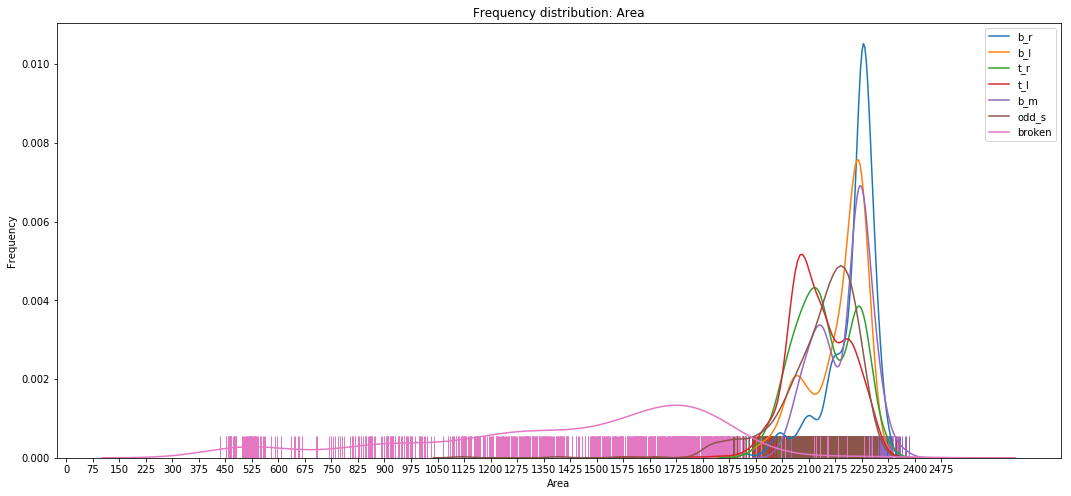

In [9]:
"""Determining the correct area threshold"""
# use area information from properties
Areas_list = []
for i in range(num_shape_cats):
    x = [h.area for h in I_thresh_props[i]]
    Areas_list.append(x) #list of areas for every category
print("Area averages: ")
[print("%s : ave - %.f var - %.f %% " %(framesetnames[i], np.average(Areas_list[i]),
                                       np.var(Areas_list[i]) *100/ np.average(Areas_list[i])
                                       )) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: Area")
plt.xlabel("Area")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Areas_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

Inertia averages: 
b_r : 409 
b_l : 400 
t_r : 427 
t_l : 424 
b_m : 430 
odd_s : 423 
broken : 274 
Inertia variances: 
b_r : 251 
b_l : 209 
t_r : 230 
t_l : 271 
b_m : 158 
odd_s : 2880 
broken : 7278 
convex_area averages: 
b_r : 2482 
b_l : 2462 
t_r : 2467 
t_l : 2437 
b_m : 2558 
odd_s : 2460 
broken : 1608 
convex_area variances: 
b_r : 3980 
b_l : 3677 
t_r : 7658 
t_l : 6656 
b_m : 2047 
odd_s : 36146 
broken : 233660 
minor_axis_length averages: 
b_r : 46 
b_l : 46 
t_r : 44 
t_l : 43 
b_m : 47 
odd_s : 45 
broken : 37 
minor_axis_length variances: 
b_r : 1 
b_l : 1 
t_r : 2 
t_l : 2 
b_m : 0 
odd_s : 24 
broken : 45 
major_axis_length averages: 
b_r : 66 
b_l : 65 
t_r : 70 
t_l : 70 
b_m : 68 
odd_s : 68 
broken : 54 
major_axis_length variances: 
b_r : 4 
b_l : 4 
t_r : 4 
t_l : 5 
b_m : 3 
odd_s : 56 
broken : 118 
solidity averages: 
b_r : 1 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 1 
odd_s : 1 
broken : 1 
solidity variances: 
b_r : 0 
b_l : 0 
t_r : 0 
t_l : 0 
b_m : 0 
odd_

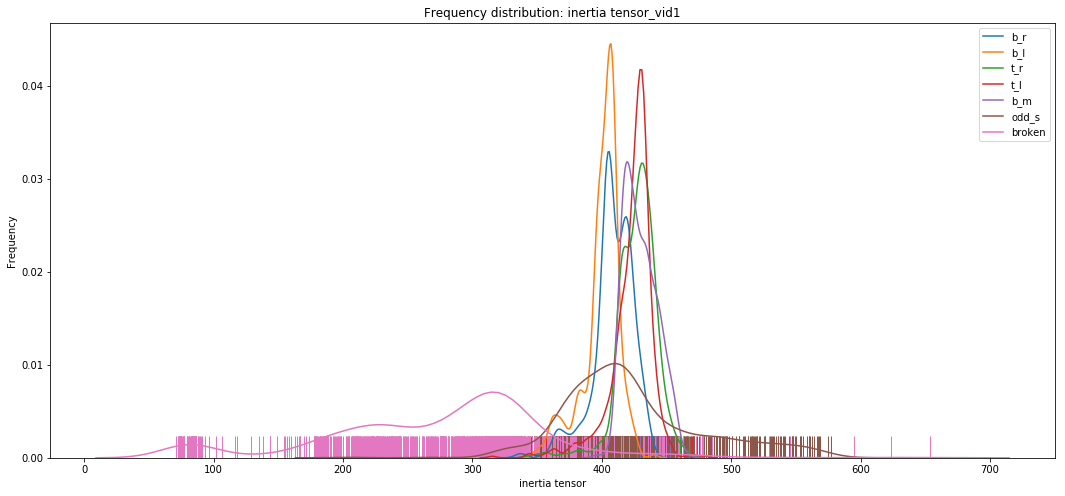

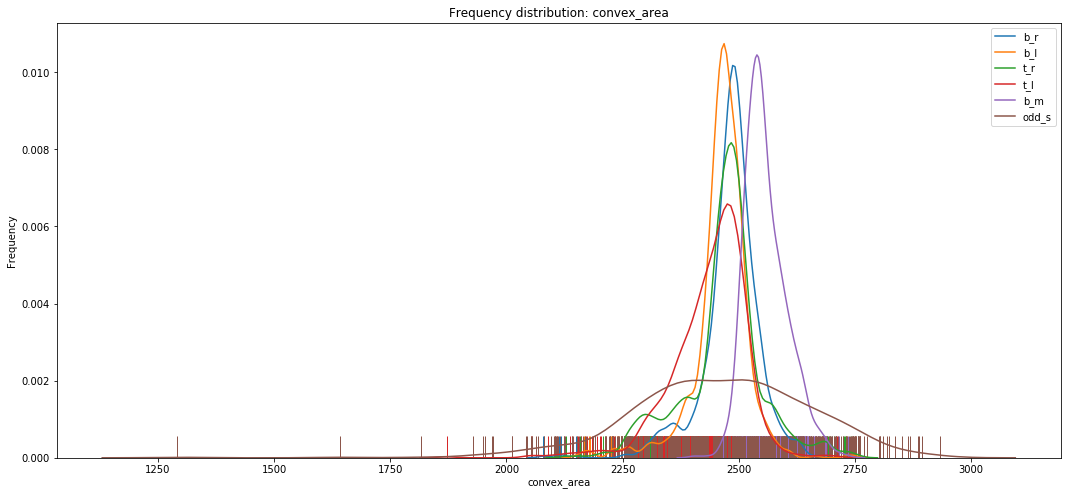

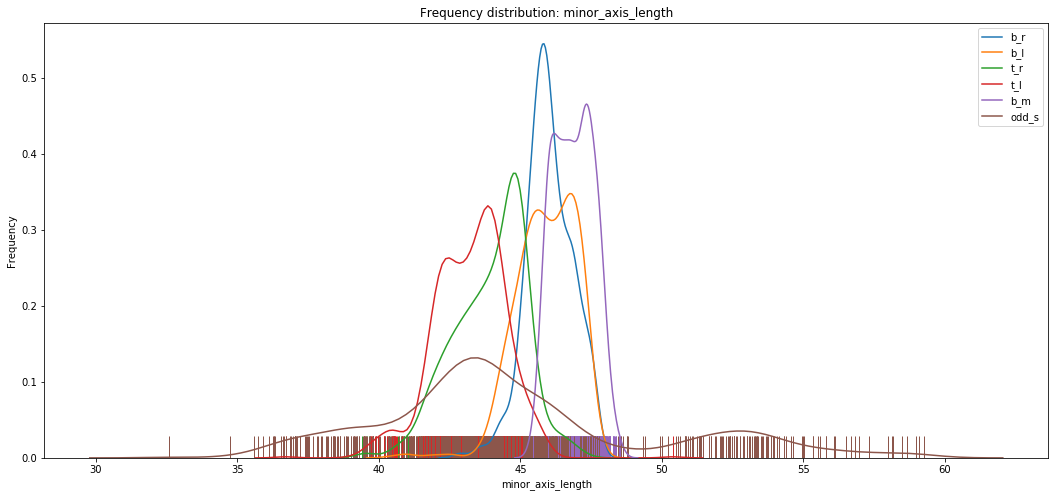

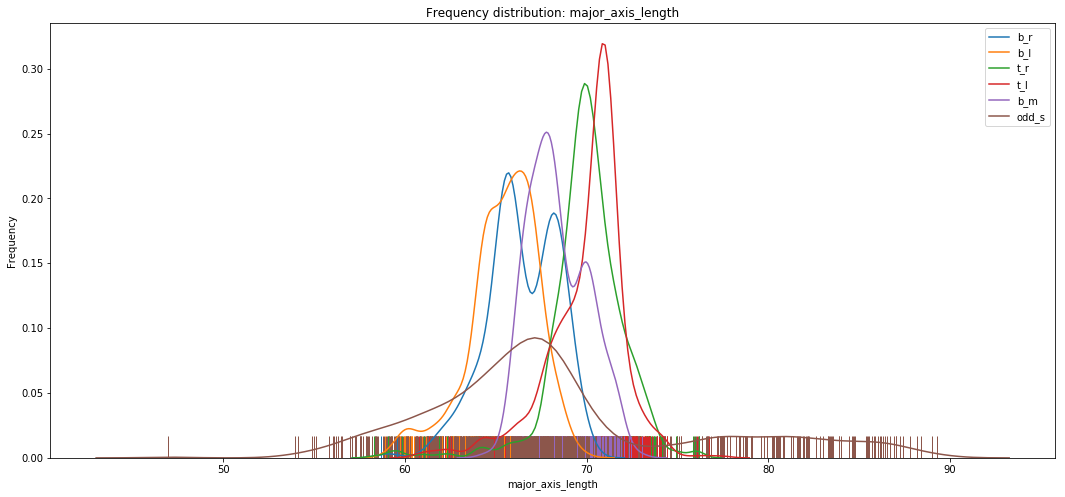

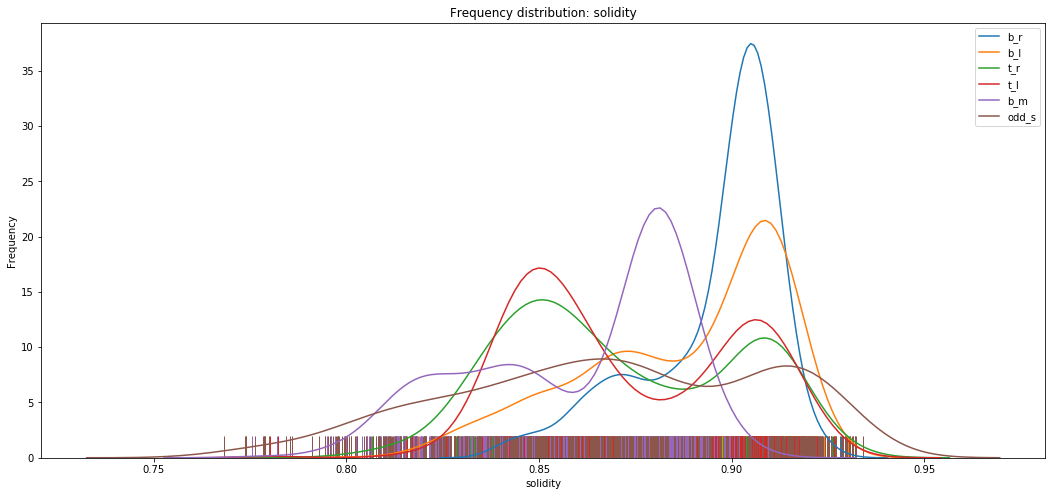

In [10]:
"""FINDING CORRECT THRESHOLDS FOR SEPARATING ODD SHAPED FRAMES"""

# use area information from properties
Inertias_list = []
for i in range(num_shape_cats):
    x = [h.inertia_tensor[0, 0] + h.inertia_tensor[1,1] for h in I_thresh_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid1")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h, propnames[k]) for h in I_thresh_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

b_r : ave - 2225 var - 201 % 
b_l : ave - 2190 var - 267 % 
t_r : ave - 2152 var - 327 % 
t_l : ave - 2136 var - 260 % 
b_m : ave - 2202 var - 257 % 
odd_s : ave - nan var - nan % 
broken : ave - nan var - nan % 


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)


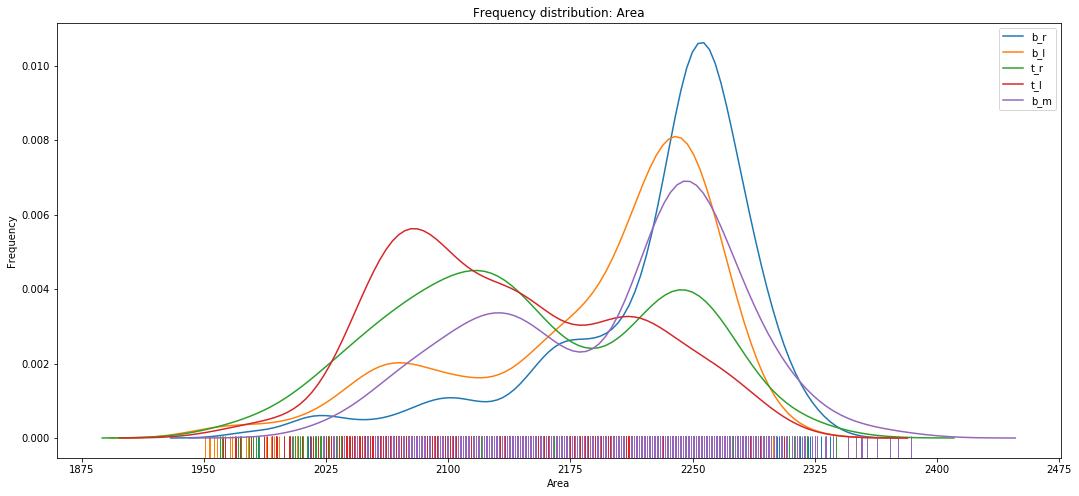

In [11]:
"""PTINTING RESULTS OF FILTERING"""
# use area information from properties
Areas_list = []
for i in range(num_shape_cats):
    x = [h[0].area for h in Filtrates_props[i]]
    Areas_list.append(x) #list of areas for every category
#print("Area averages: ")
[print("%s : ave - %.f var - %.f %% " %(framesetnames[i], np.average(Areas_list[i]),
                                   np.var(Areas_list[i])*100/ np.average(Areas_list[i])
                                  )) for i in range(num_shape_cats)]
fig, ax = plt.subplots(figsize=(18,8))
plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: Area")
plt.xlabel("Area")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Areas_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
   


Inertia averages: 
b_r : 409 
b_l : 401 
t_r : 429 
t_l : 425 
b_m : 430 
odd_s : nan 
broken : nan 
Inertia variances: 
b_r : 221 
b_l : 171 
t_r : 138 
t_l : 146 
b_m : 155 
odd_s : nan 
broken : nan 
convex_area averages: 
b_r : 2484 
b_l : 2465 
t_r : 2476 
t_l : 2448 
b_m : 2559 
odd_s : nan 
broken : nan 
convex_area variances: 
b_r : 3274 
b_l : 3114 
t_r : 6429 
t_l : 3813 
b_m : 1995 
odd_s : nan 
broken : nan 
minor_axis_length averages: 
b_r : 46 
b_l : 46 
t_r : 44 
t_l : 43 
b_m : 47 
odd_s : nan 
broken : nan 
minor_axis_length variances: 
b_r : 1 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 0 
odd_s : nan 
broken : nan 
major_axis_length averages: 
b_r : 66 
b_l : 66 
t_r : 70 
t_l : 70 
b_m : 68 
odd_s : nan 
broken : nan 
major_axis_length variances: 
b_r : 4 
b_l : 3 
t_r : 2 
t_l : 3 
b_m : 3 
odd_s : nan 
broken : nan 
solidity averages: 
b_r : 1 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 1 
odd_s : nan 
broken : nan 
solidity variances: 
b_r : 0 
b_l : 0 
t_r : 0 
t_l : 0 
b_m : 0 
od

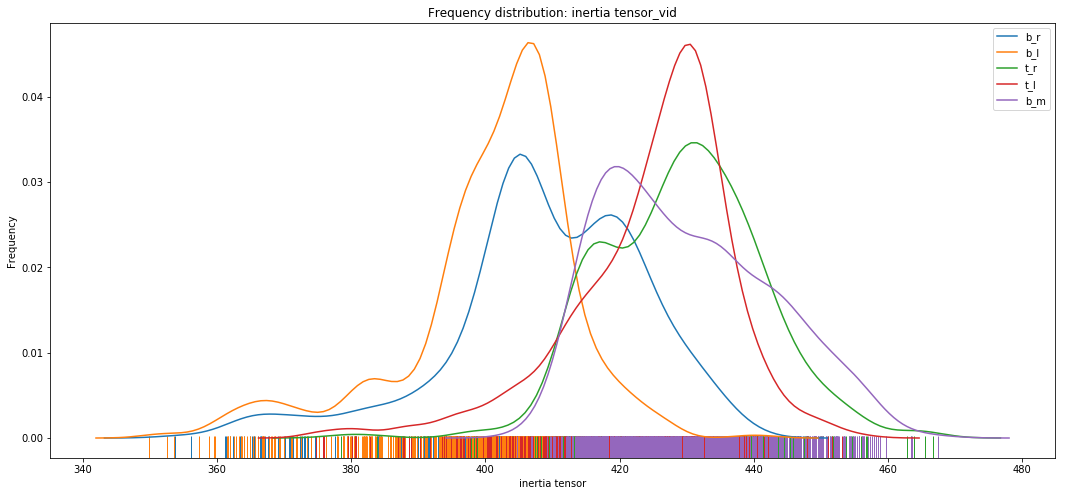

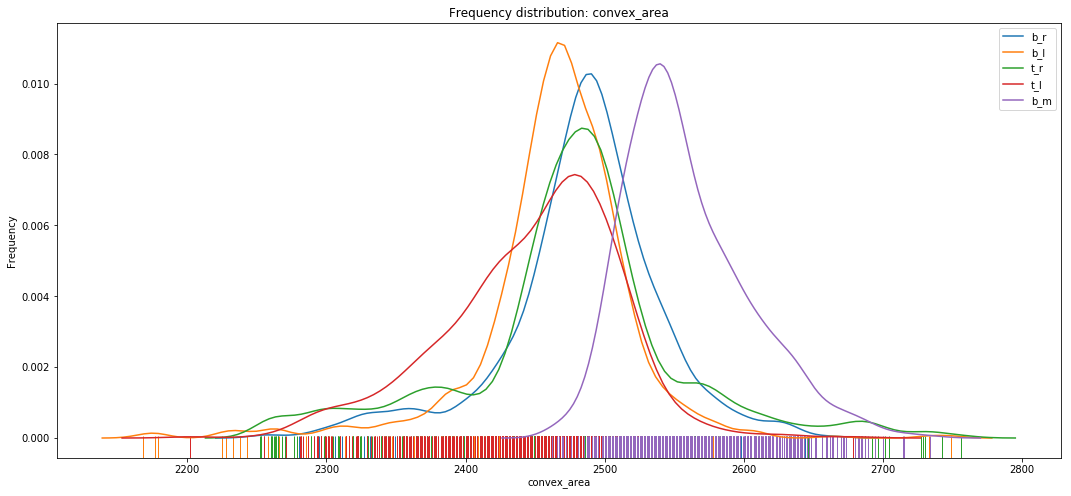

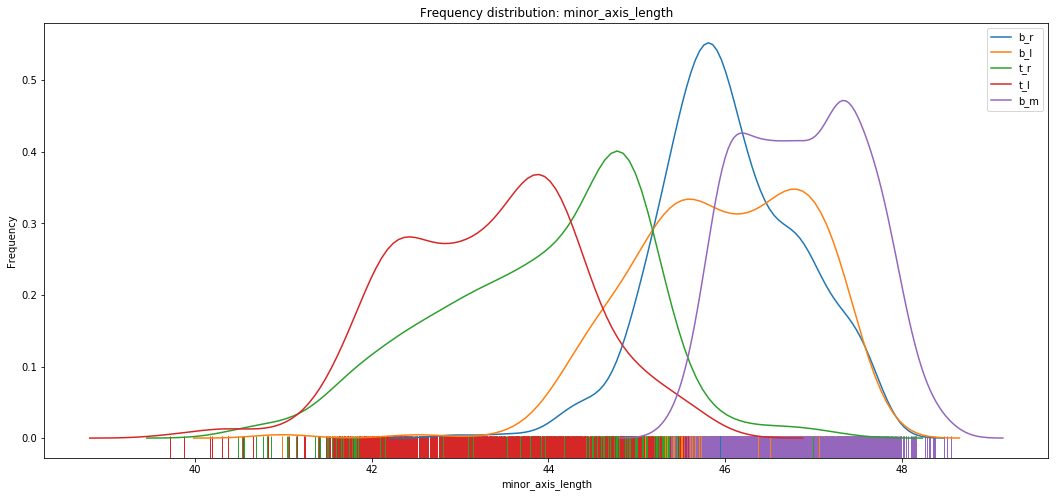

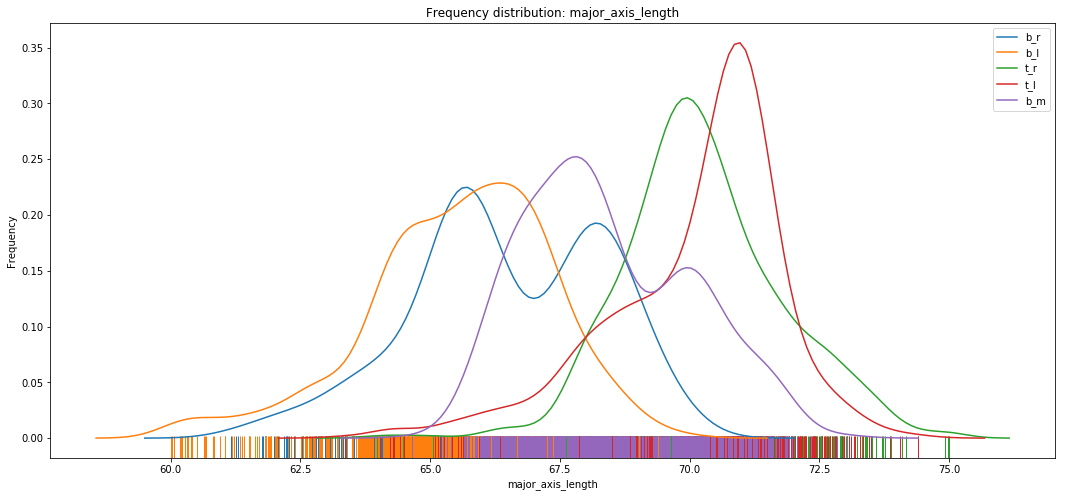

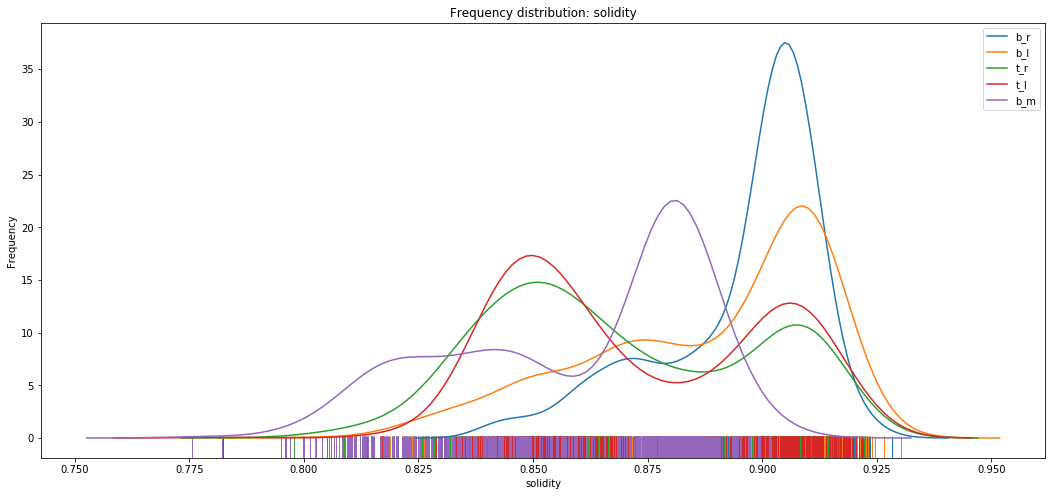

In [12]:
"""STILL RESULTS OF FILTERING"""
Inertias_list = []
for i in range(num_shape_cats):
    x = [h[0].inertia_tensor[0, 0] + h[0].inertia_tensor[1,1] for h in Filtrates_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[0], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])


In [13]:
"""Pt3. Separating variosu shapes
"""

'Pt3. Separating variosu shapes\n'

In [14]:
"SEE HOW THE ISODATA FILTER TREATS FRAMES - UNFILTERED"

                                           

'SEE HOW THE ISODATA FILTER TREATS FRAMES - UNFILTERED'

dist_from_cen averages: 
b_r : 24 
b_l : 22 
t_r : 10 
t_l : 10 
b_m : 2 
odd_s : 14 
broken : 9 
dist_from_cen variances: 
b_r : 5 
b_l : 7 
t_r : 6 
t_l : 11 
b_m : 3 
odd_s : 82 
broken : 71 


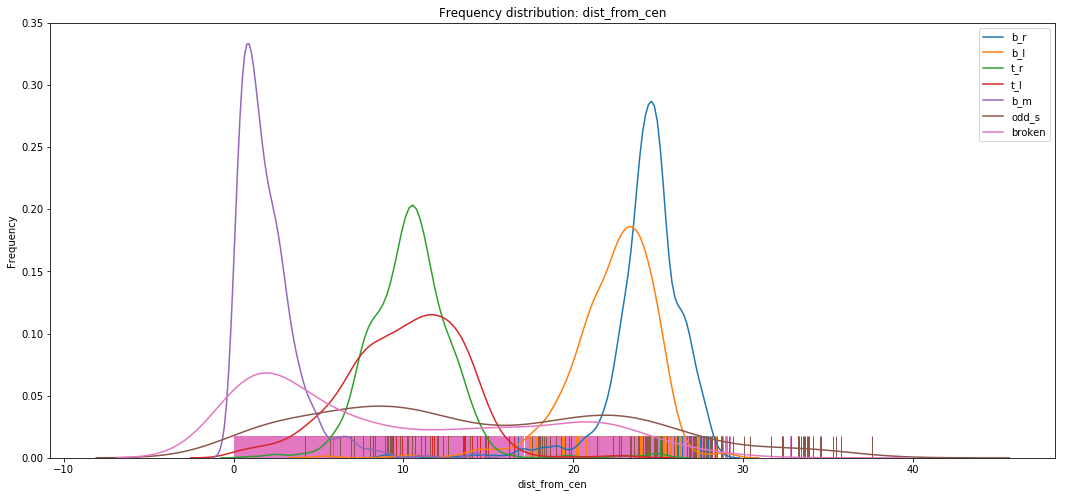

In [15]:
"""COMPARING A MEASIREMENT ACROSS THRESHOLDS"""
propnames = ["dist_from_cen"] # distance of transparent do fornm center
m_lab = measure.label
m_rop = measure.regionprops
for k in range(0, len(propnames)):
    klist = []
    for x in range(num_shape_cats):
        lens = []
        for limg_pair in limgs[x]:
            full = morphology.dilation(morphology.closing(largest_region_extractor(limg_pair[0])))
            four = morphology.dilation(morphology.closing(largest_region_extractor(limg_pair[1])))
            full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
            one_and_some = full^four
            one = largest_region_extractor(measure.label(one_and_some))
            rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
            rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
            geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].centroid#m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
            #print(geo_cent)

            cent_x = int(geo_cent[1])#int(ave([geo_cent[1], geo_cent[3]]) )
            cent_y = int(geo_cent[0])#int(ave([geo_cent[0], geo_cent[2]]))
            #print(cent_x, cent_y)
            if len(m_rop(rotated_one.astype(int))) != 0:
                one_com = (m_rop(rotated_one.astype(int)))[0].centroid
                #print(one_com[0].centroid)
                rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y) # vector of com of the dot relative to geometric center
                #print("com of dot relative geo_cent", rel_com_one, np.prod(rel_com_one))


                raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
                ys = raw_coords[0]
                xs = raw_coords[1]
                length = abs(rel_com_one[1]) # y-value of relative com of dot
                lens.append(length)
        klist.append(lens) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        


Inertia averages: 
b_r : 311 
b_l : 307 
t_r : 392 
t_l : 387 
b_m : 426 
odd_s : 341 
broken : 398 
Inertia variances: 
b_r : 125 
b_l : 112 
t_r : 172 
t_l : 411 
b_m : 126 
odd_s : 3213 
broken : 1357 
Inertia averages: 
b_r : 311 
b_l : 307 
t_r : 393 
t_l : 388 
b_m : 426 
odd_s : nan 
broken : nan 
Inertia variances: 
b_r : 125 
b_l : 112 
t_r : 124 
t_l : 266 
b_m : 121 
odd_s : nan 
broken : nan 
area averages: 
b_r : 1425 
b_l : 1426 
t_r : 1404 
t_l : 1408 
b_m : 1417 
odd_s : 1358 
broken : 1301 
area variances: 
b_r : 1280 
b_l : 1475 
t_r : 2180 
t_l : 1543 
b_m : 1646 
odd_s : 23974 
broken : 7365 
area averages: 
b_r : 1425 
b_l : 1426 
t_r : 1404 
t_l : 1412 
b_m : 1417 
odd_s : nan 
broken : nan 
area variances: 
b_r : 1281 
b_l : 1432 
t_r : 2208 
t_l : 1066 
b_m : 1654 
odd_s : nan 
broken : nan 
convex_area averages: 
b_r : 1895 
b_l : 1889 
t_r : 1957 
t_l : 1953 
b_m : 2181 
odd_s : 1872 
broken : 1967 
convex_area variances: 
b_r : 16701 
b_l : 15421 
t_r : 4856 

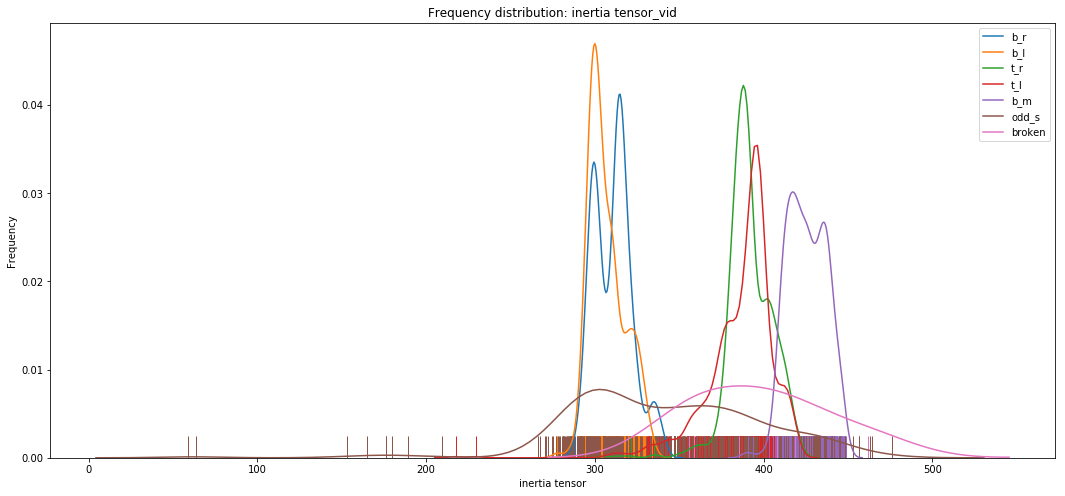

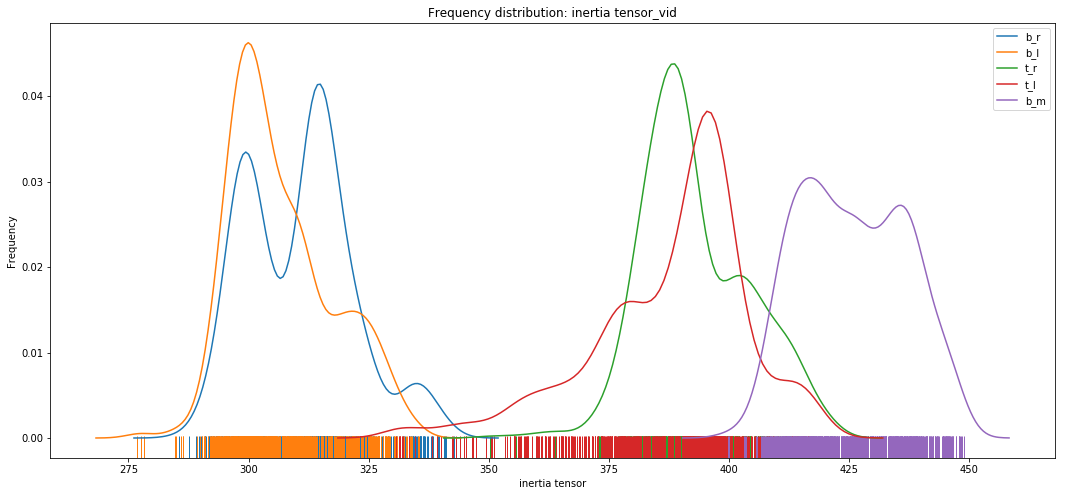

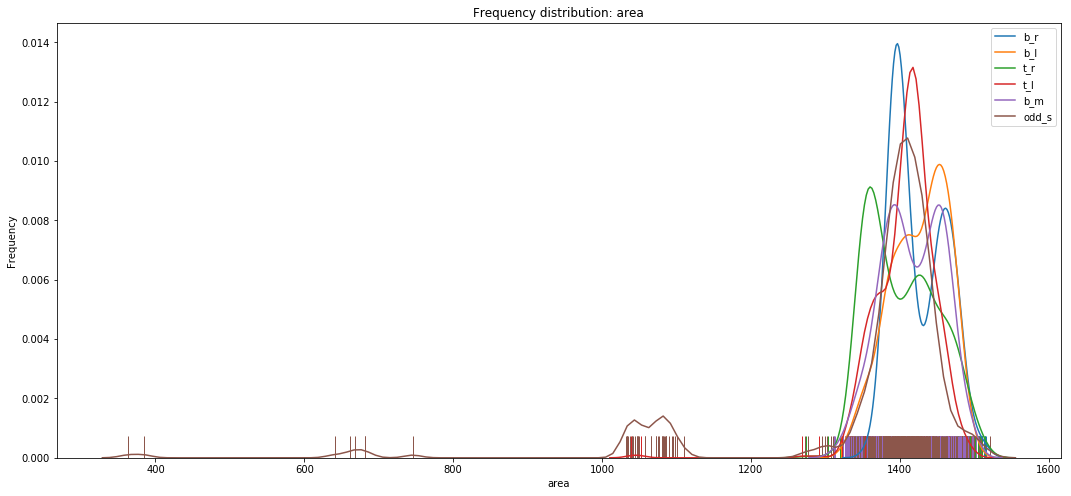

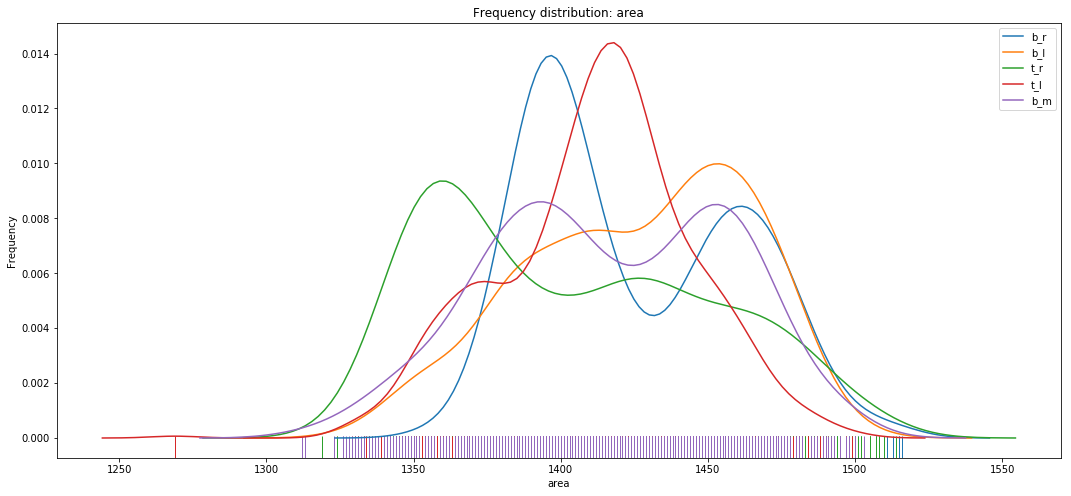

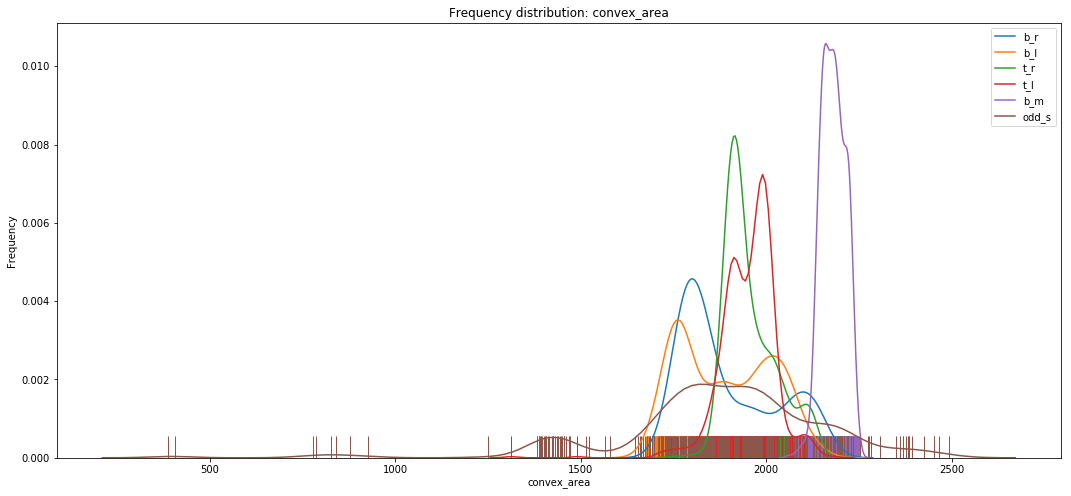

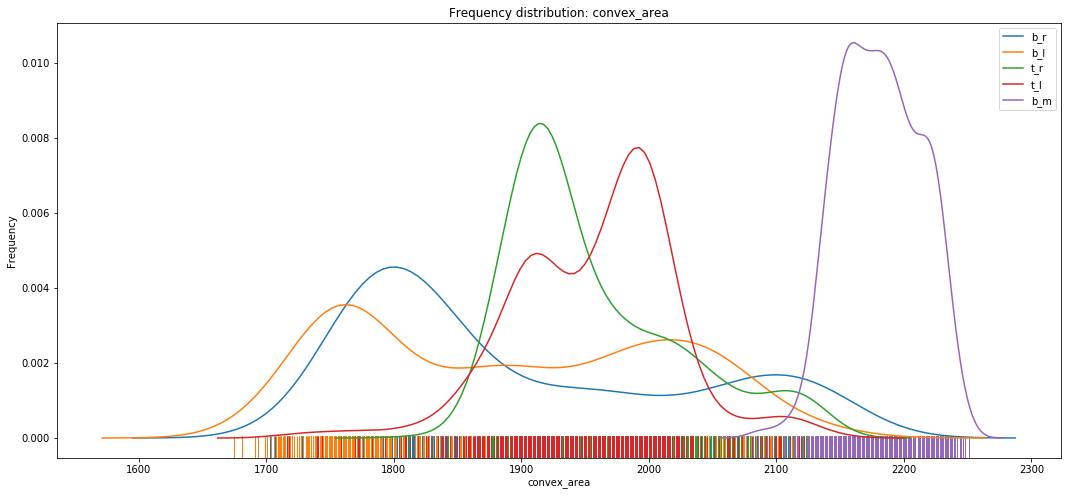

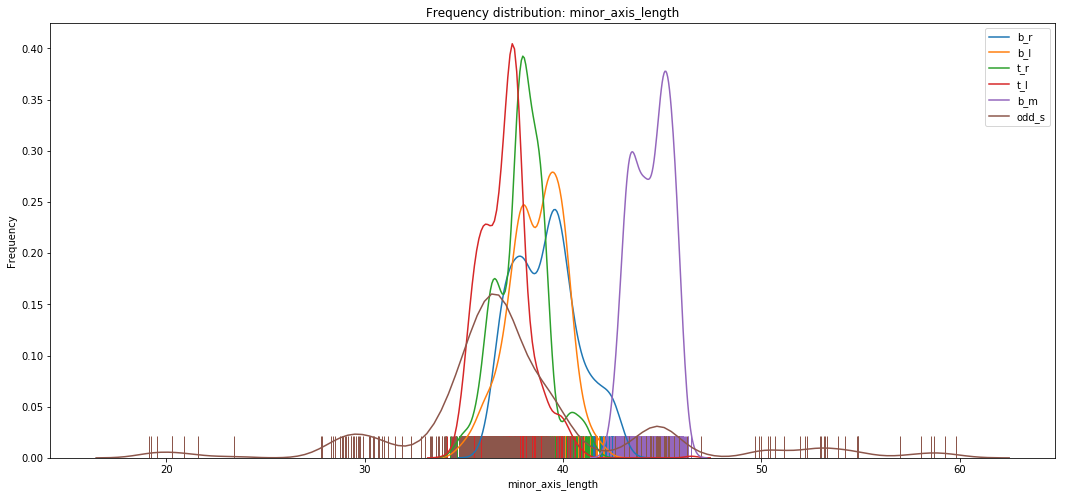

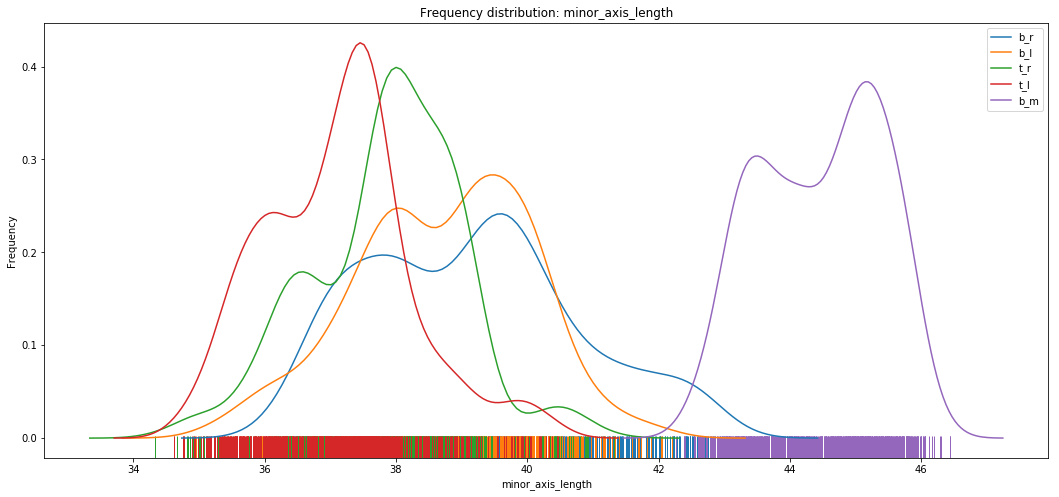

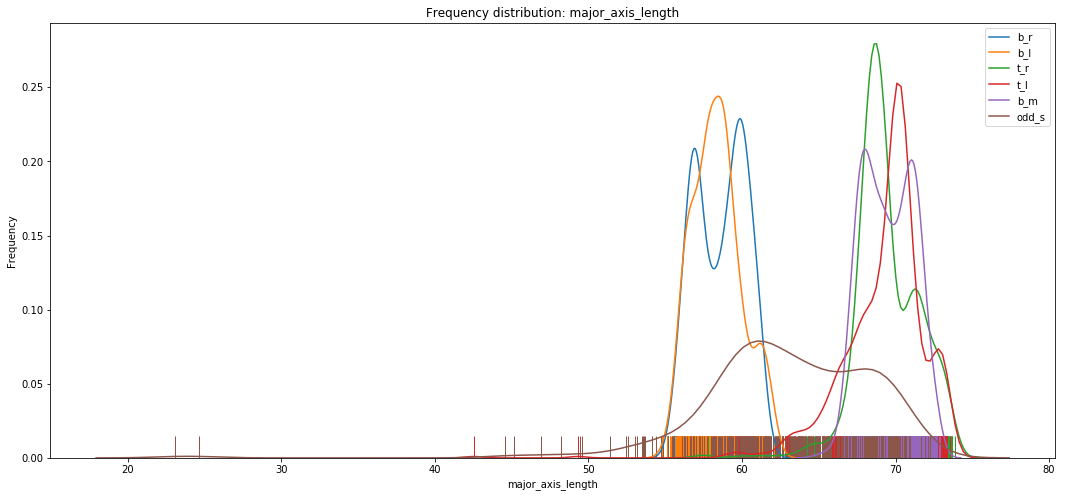

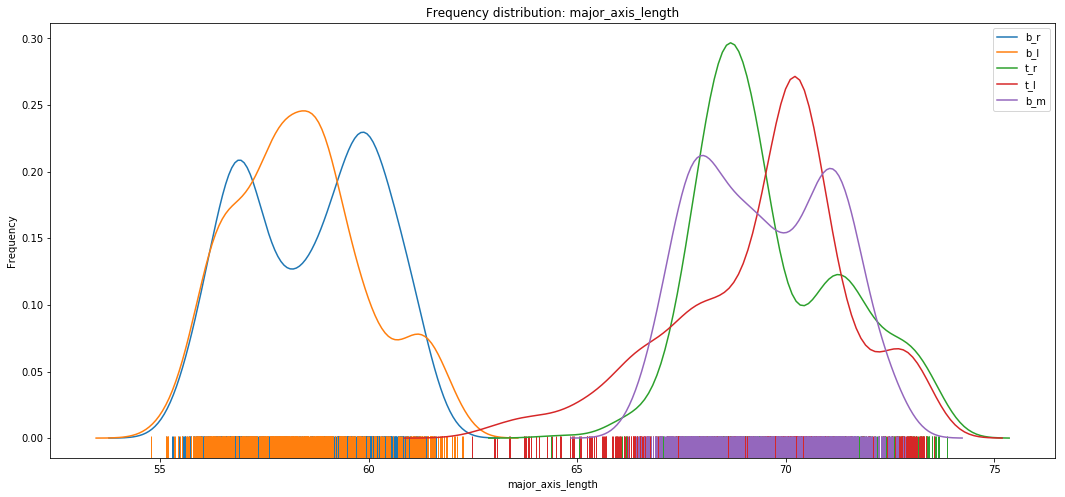

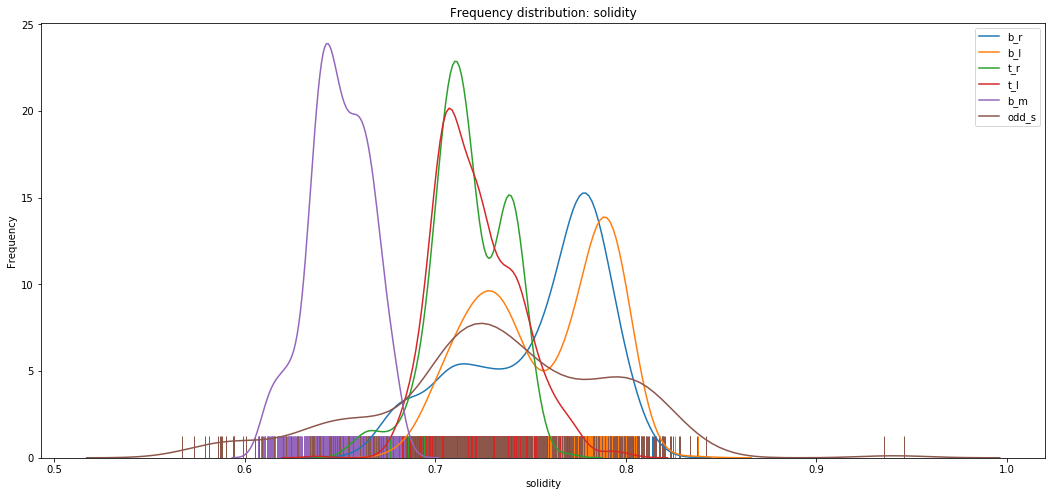

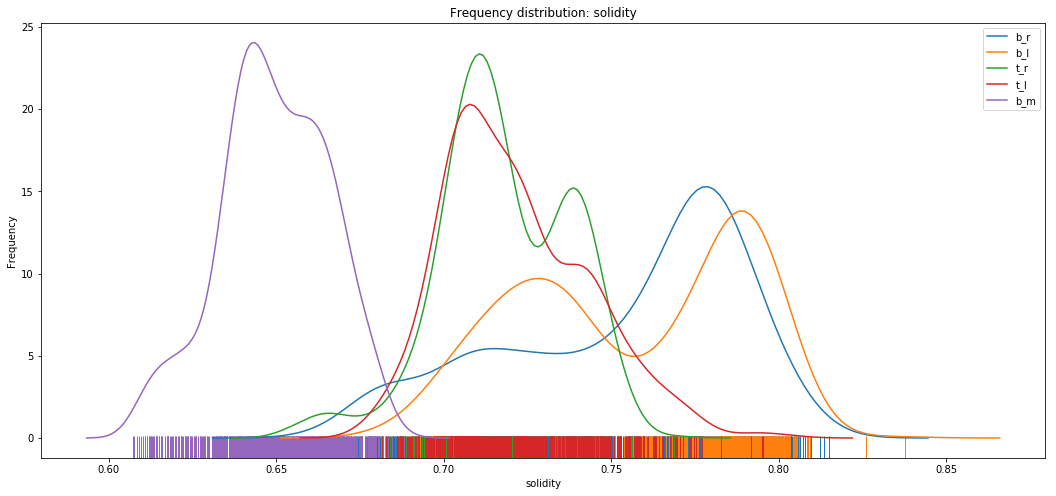

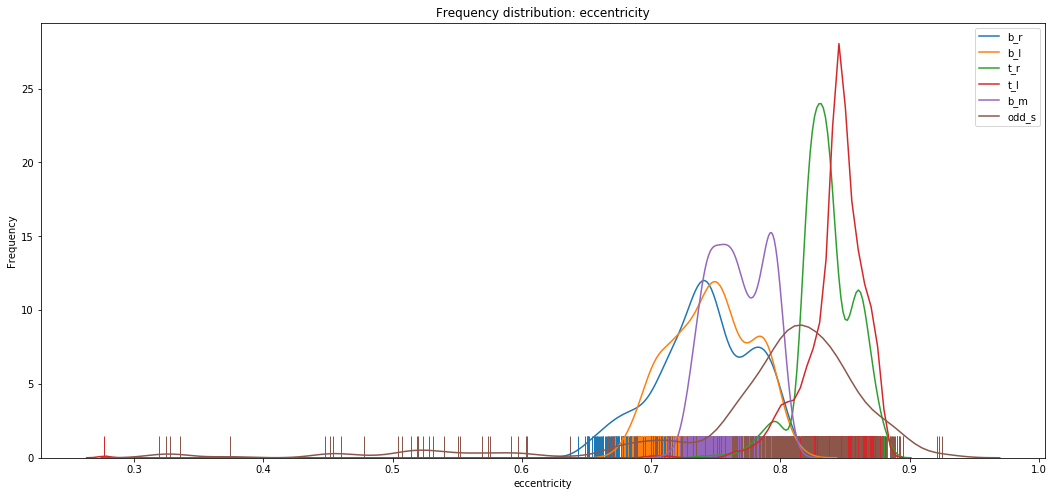

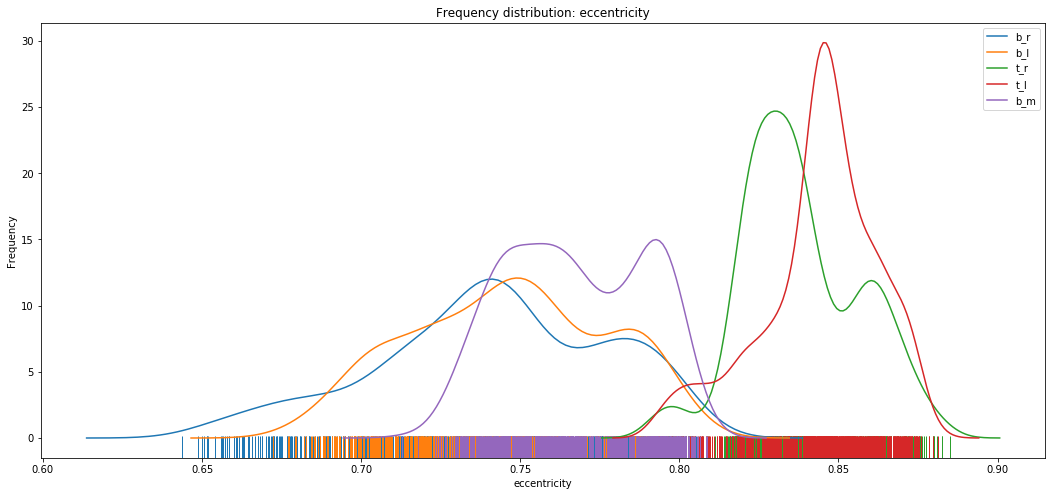

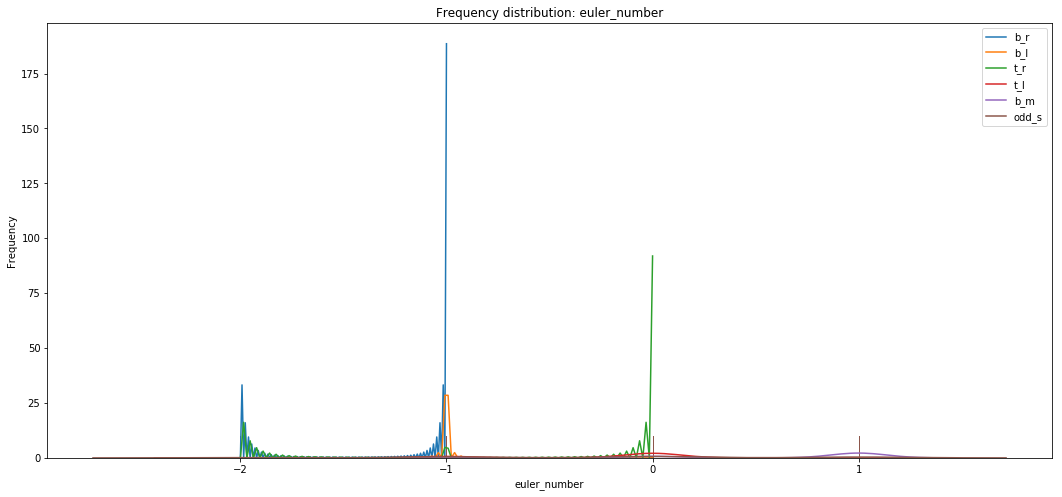

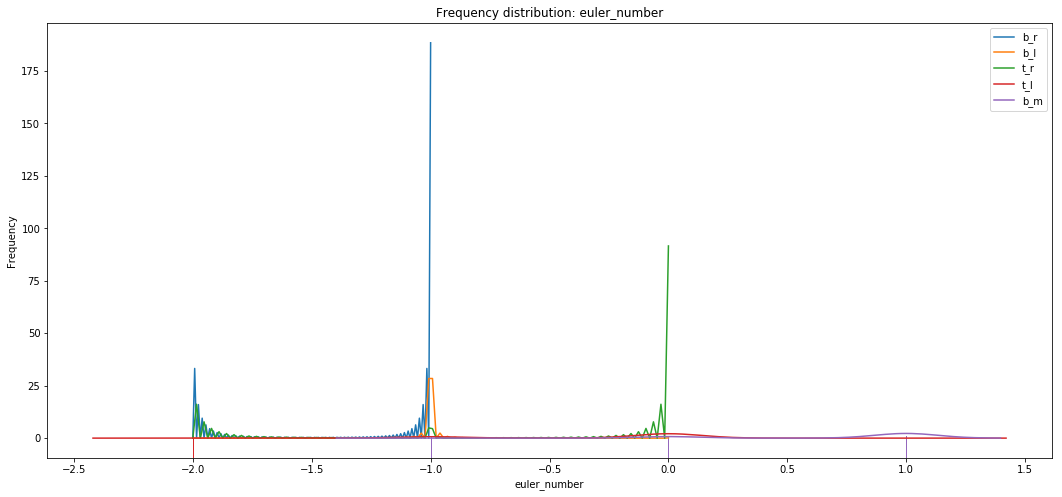

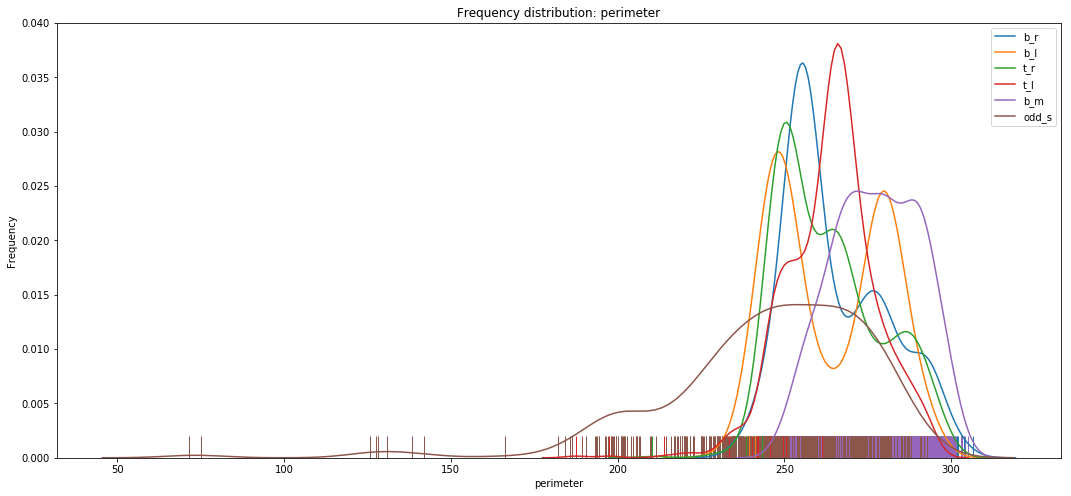

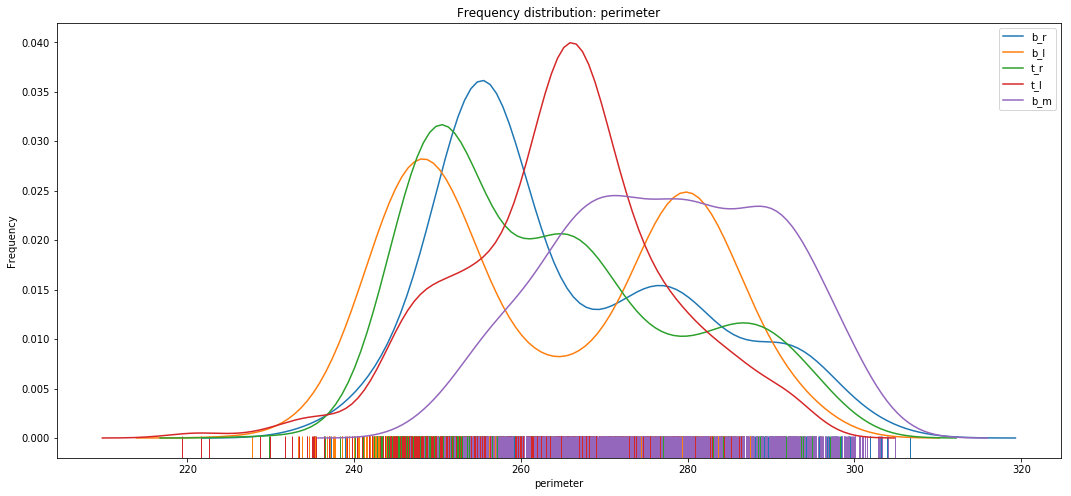

In [16]:
"""FINDING CORRECT THRESHOLDS FOR SHAPE DISCRIMINATION"""

"""STILL RESULTS OF FILTERING"""
Inertias_list = []
for i in range(num_shape_cats):
    x = [h.inertia_tensor[0, 0] + h.inertia_tensor[1,1] for h in conditional_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

    
Inertias_list = []
for i in range(num_shape_cats):
    x = [h[1].inertia_tensor[0, 0] + h[1].inertia_tensor[1,1] for h in Filtrates_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
    
    
    
    
propnames = ["area", "convex_area", "minor_axis_length", "major_axis_length", "solidity", "eccentricity", "euler_number", "perimeter"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h, propnames[k]) for h in conditional_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[1], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        
        


# don't use: extent, perimeter, minor axis lengths, solidity, eccetricity
# inertia: 300 - 360 br/bl, 350 - 415 tr/tl, 417/412 - bm
# mal: 56 - 63 br/bl, 63 - 70 tr/tl, 68 bm
# ecc: .63 - .78 br/bl, .76 - .83 tr/tl, .76 bm

# if solidity <= .76 and inertia > 400 => bm
# elif inertia >=355 and mal >= 63 => tl/tr
# elif inertia <= 355 and mal <= 63 => bl/br
# else unclassifiable

In [17]:
"""DO A PCA ON EACH OF THE SETS AND PLOT SEPARATION. DISPLAY PRINCIPAL AXIS LOADINGS"""

'DO A PCA ON EACH OF THE SETS AND PLOT SEPARATION. DISPLAY PRINCIPAL AXIS LOADINGS'